In [1]:
import pandas as pd
import os
from pprint import pprint
import googlemaps
import requests
import numpy as np
import altair as alt
from vega_datasets import data

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

### LOAD DATA

In [21]:
merged_df = pd.read_csv('../data/us_wineries_with_counties.csv')
cleaned_df = pd.read_csv('../data/cleaned_data.csv', index_col=0)

In [22]:
cleaned_df.head()

,points,title,description,taster_name,taster_twitter_handle,price,designation,variety,region_1,region_2,state,country,winery,county,county_id,state_id,value
0,87,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Alexander Peartree,NaN,13.0,Reserve Late Harvest,Riesling,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,26159,26,6.692308
1,85,St. Julian NV Cathermsn's Port (Lake Michigan ...,Stewed fig and blackberry aromas meet a dried ...,Alexander Peartree,NaN,16.0,Cathermsn's,Port,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,26159,26,5.312500
2,83,St. Julian 2013 Braganini Reserve Traminette (...,A citrus-rind aroma takes on an earthy bee-pol...,Alexander Peartree,NaN,15.0,Braganini Reserve,Traminette,Michigan,NaN,Michigan,US,St. Julian,Van Buren County,26159,26,5.533333
3,86,St. Julian NV Solera Cream Sherry (Lake Michig...,Aromas of roasted almond and pecan meet dried ...,Alexander Peartree,NaN,16.0,Solera Cream,Sherry,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,26159,26,5.375000
4,88,St. Julian 2013 Braganini Reserve Late Harvest...,Candied peach and apricot aromas meld with dus...,Alexander Peartree,NaN,20.0,Braganini Reserve Late Harvest,Vignoles,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,26159,26,4.400000


### CLEAN MISLABELED COLUMNS

In [7]:
merged_df.loc[(merged_df['county'] == 'Yamhill County') & (merged_df['province'] == 'America'), 'province'] = 'Oregon'
merged_df.loc[(merged_df['county'] == 'Bernalillo County') & (merged_df['province'] == 'America'), 'province'] = 'New Mexico'
merged_df.loc[(merged_df['county'] == 'Buncombe County') & (merged_df['province'] == 'America'), 'province'] = 'North Carolina'
merged_df.loc[(merged_df['county'] == 'Steuben County') & (merged_df['province'] == 'America'), 'province'] = 'New York'
merged_df.loc[(merged_df['county'] == 'Canyon County') & (merged_df['province'] == 'America'), 'province'] = 'Idaho'
merged_df.loc[(merged_df['county'] == 'Santa Barbara County') & (merged_df['province'] == 'America'), 'province'] = 'California'
merged_df.loc[(merged_df['county'] == 'Benton County') & (merged_df['province'] == 'America'), 'province'] = 'Washington'
merged_df.loc[(merged_df['county'] == 'Yavapai County') & (merged_df['province'] == 'America'), 'province'] = 'Arizona'
merged_df.loc[(merged_df['county'] == 'King County') & (merged_df['province'] == 'America'), 'province'] = 'Washington'
merged_df.loc[(merged_df['county'] == 'St. Charles County') & (merged_df['province'] == 'America'), 'province'] = 'Missouri'
merged_df.loc[(merged_df['county'] == 'Barnstable County') & (merged_df['province'] == 'America'), 'province'] = 'Massachusetts'
merged_df.loc[(merged_df['county'] == 'Gem County') & (merged_df['province'] == 'America'), 'province'] = 'Idaho'
merged_df.loc[(merged_df['county'] == 'Culpeper County') & (merged_df['province'] == 'America'), 'province'] = 'Virginia'
merged_df.loc[(merged_df['county'] == 'Washington County') & (merged_df['province'] == 'America'), 'province'] = 'Oregon'
merged_df.loc[(merged_df['county'] == 'Denver County') & (merged_df['province'] == 'America'), 'province'] = 'Colorado'
merged_df.loc[(merged_df['county'] == 'Nez Perce County') & (merged_df['province'] == 'America'), 'province'] = 'Idaho'
merged_df.loc[(merged_df['county'] == 'Worcester County') & (merged_df['province'] == 'America'), 'province'] = 'Maryland'
merged_df.loc[(merged_df['county'] == 'Barrow County') & (merged_df['province'] == 'America'), 'province'] = 'Georgia'
merged_df.loc[(merged_df['county'] == 'Sonoma County') & (merged_df['province'] == 'America'), 'province'] = 'California'
merged_df.loc[(merged_df['county'] == 'Windham County') & (merged_df['province'] == 'America'), 'province'] = 'Vermont'
merged_df.loc[(merged_df['county'] == 'Polk County') & (merged_df['province'] == 'America'), 'province'] = 'Florida'
merged_df.loc[(merged_df['county'] == 'Napa County') & (merged_df['province'] == 'America'), 'province'] = 'California'
merged_df.loc[(merged_df['county'] == 'Warren County') & (merged_df['province'] == 'America'), 'province'] = 'New York'
merged_df.loc[(merged_df['county'] == 'Jackson County') & (merged_df['province'] == 'America'), 'province'] = 'Illinois'
merged_df.loc[(merged_df['county'] == 'Monroe County') & (merged_df['province'] == 'America'), 'province'] = 'Indiana'
merged_df.loc[(merged_df['county'] == 'Cook County') & (merged_df['province'] == 'Washington-Oregon'), 'province'] = 'Washington'
merged_df.loc[(merged_df['county'] == 'Lane County') & (merged_df['province'] == 'Washington-Oregon'), 'province'] = 'Oregon'
merged_df.loc[(merged_df['county'] == 'Yamhill County') & (merged_df['province'] == 'Washington-Oregon'), 'province'] = 'Oregon'
merged_df.loc[(merged_df['county'] == 'Multnomah County') & (merged_df['province'] == 'Washington-Oregon'), 'province'] = 'Oregon'

### GET THE US-ATLAS COUNTY AND STATE IDENTIFIERS

In [8]:
# Get Counties
counties_url = 'https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json'
counties = requests.get(counties_url)
counties_data = counties.json()

# Get States
states_url = 'https://cdn.jsdelivr.net/npm/us-atlas@3/states-10m.json'
states = requests.get(states_url)
states_data = states.json()

### MAP THE COUNTY AND STATE IDS TO THE MERGED DF

In [10]:
# Get the list of geometry dictionaries which contain county/state name and ID
counties = counties_data['objects']['counties']['geometries']
states = states_data['objects']['states']['geometries']

def extract_ids(identifier):
    """
    Get a dictionary of the state/county name and corresponding id.
    
    Parameters:
    -----------
    identifier -- (dict) state or county dictionary with name and id
    
    Returns a dictionary of mapped state/county names and ids.
    """
    data = {}
    for item in identifier:
        # Remove leading '0' for correct mapping later
        if item['id'][0] == '0':
            item['id'] = item['id'][1:]
        data[item['properties']['name']] = item['id']
    return data

# Get the states and counties dicts
counties_dict = extract_ids(counties)
states_dict = extract_ids(states)

# Add an 'id' columns to the df for state and county
merged_df['county_id'] = np.nan
merged_df['state_id'] = np.nan

# Rename the 'province' column to 'state'
merged_df = merged_df.rename(columns={'province': 'state'})

# Copy the df to iterate over and add ids
merged_copy = merged_df.copy()

# Add county id's to merged df row by county name
for i, row in merged_copy.iterrows():
    county = row['county'].replace(' County', '')
    state = row['state']
    
    # Continue if state or county can't be matched
    if counties_dict.get(county, None) is None:
        continue
    if states_dict.get(state, None) is None:
        continue
    
    merged_df.loc[i, 'county_id'] = counties_dict[county]
    merged_df.loc[i, 'state_id'] = states_dict[state]
    

In [12]:
merged_df.head()

,Unnamed: 0,points,title,description,taster_name,taster_twitter_handle,price,designation,variety,region_1,region_2,state,country,winery,county,county_id,state_id
0,0,87,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Alexander Peartree,NaN,13.0,Reserve Late Harvest,Riesling,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,47175,26
1,1,85,St. Julian NV Cathermsn's Port (Lake Michigan ...,Stewed fig and blackberry aromas meet a dried ...,Alexander Peartree,NaN,16.0,Cathermsn's,Port,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,47175,26
2,2,83,St. Julian 2013 Braganini Reserve Traminette (...,A citrus-rind aroma takes on an earthy bee-pol...,Alexander Peartree,NaN,15.0,Braganini Reserve,Traminette,Michigan,NaN,Michigan,US,St. Julian,Van Buren County,47175,26
3,3,86,St. Julian NV Solera Cream Sherry (Lake Michig...,Aromas of roasted almond and pecan meet dried ...,Alexander Peartree,NaN,16.0,Solera Cream,Sherry,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,47175,26
4,4,88,St. Julian 2013 Braganini Reserve Late Harvest...,Candied peach and apricot aromas meld with dus...,Alexander Peartree,NaN,20.0,Braganini Reserve Late Harvest,Vignoles,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,47175,26


### CLEAN DATA WITH MISSING COUNTY ID's

In [13]:
merged_df = merged_df[pd.notnull(merged_df['county_id'])]

### ANALYSE THE FILTERED AND CLEANED DF

In [14]:
print("There are {:,.0f} total ratings.\n".format(len(merged_df)))
print(f"There are {len(merged_df.country.unique())} unique countries represented.\n")
print(f"There are {len(merged_df.state.unique())} unique states represented.\n")
print(f"There are {len(merged_df.region_1.unique())} unique region 1's represented.\n")
print(f"There are {len(merged_df.region_2.unique())} unique region 2's represented.\n")
print(f"There are {len(merged_df.variety.unique())} unique varieties.\n")
print("There are {:,.0f} unique wineries.\n".format(len(merged_df.winery.unique())))
print(f"There are {len(merged_df.taster_name.unique())} tasters.\n")
print("The price ranges from ${:,.0f} to ${:,.0f} per bottle.\n".format(merged_df.price.min(), merged_df.price.max()))
print("The average price is ${:,.0f} per bottle.\n".format(merged_df.price.mean()))
print("The points range from {:,.0f} to {:,.0f} per bottle.\n".format(merged_df.points.min(), merged_df.points.max()))
print("The average point rating is {:,.0f} per bottle.\n".format(merged_df.points.mean()))
print(f"There are {merged_df.region_1.isna().sum()} missing values in region_1\n")
print("There are {:,.0f} missing values in region_2\n".format(merged_df.region_2.isna().sum()))

There are 50,576 total ratings.

There are 1 unique countries represented.

There are 29 unique states represented.

There are 259 unique region 1's represented.

There are 18 unique region 2's represented.

There are 253 unique varieties.

There are 4,501 unique wineries.

There are 16 tasters.

The price ranges from $4 to $750 per bottle.

The average price is $37 per bottle.

The points range from 80 to 100 per bottle.

The average point rating is 89 per bottle.

There are 276 missing values in region_1

There are 3,793 missing values in region_2



### DISPLAY CHOROPLETH MAP OF THE US

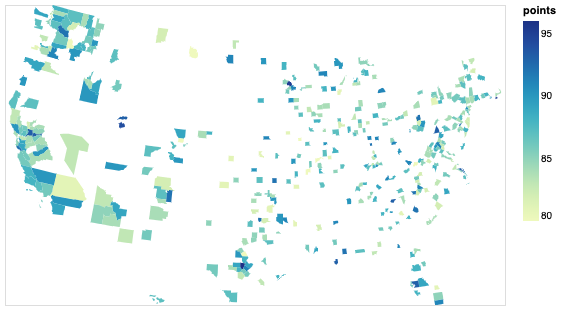

In [18]:
alt.data_transformers.disable_max_rows()

counties = alt.topo_feature(data.us_10m.url, 'counties')

alt.Chart(counties).mark_geoshape().encode(
    color='points:Q'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(merged_df, 'county_id', ['points'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)

### Adding outline for the non-null values

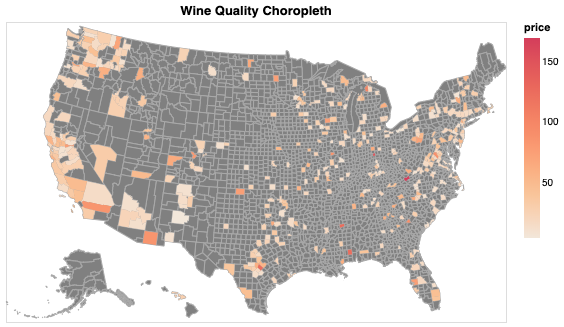

In [146]:
states = alt.topo_feature(data.us_10m.url, 'states')

foreground = alt.Chart(counties).mark_geoshape().encode(
    alt.Color('price:Q', scale=alt.Scale(scheme='lightorange'))
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(merged_df, 'county_id', ['price'])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300
)  

background = alt.Chart(counties).mark_geoshape(
    fill='grey',
    stroke='darkgrey', 
    opacity=1
).properties(
    title='Wine Quality Choropleth',
    width=500,
    height=300
).project('albersUsa')

background + foreground

### DISPLAY CHOROPLETH MAP OF PARTICULAR STATE

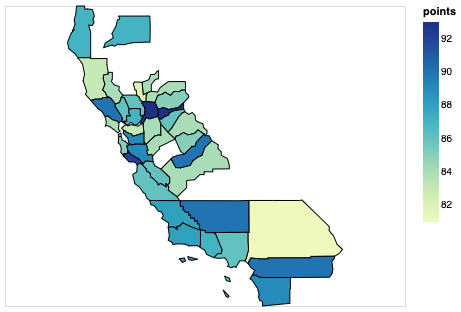

In [19]:
counties = alt.topo_feature(data.us_10m.url, 'counties')

state_id = 6 #California = 6

map_state =(
    alt.Chart(counties)
    .mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
        color='points:Q')
    .transform_calculate(state_id = "(datum.id / 1000)|0")
    .transform_filter((alt.datum.state_id)==state_id)
    .transform_lookup(
        lookup='id',
        from_=alt.LookupData(merged_df, 'county_id', ['points']))

)

map_state

### TYPES OF PLOTS WE CAN MAKE WITH THE DATASET

In [154]:
merged_df.head()
# We want to make a new column called "value" - how are we doing this?
# The prices range from 4 - 750 and we want an inverse score 

,Unnamed: 0,points,title,description,taster_name,taster_twitter_handle,price,designation,variety,region_1,region_2,state,country,winery,county,county_id,state_id
0,0,87,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Alexander Peartree,NaN,13.0,Reserve Late Harvest,Riesling,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,47175,26
1,1,85,St. Julian NV Cathermsn's Port (Lake Michigan ...,Stewed fig and blackberry aromas meet a dried ...,Alexander Peartree,NaN,16.0,Cathermsn's,Port,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,47175,26
2,2,83,St. Julian 2013 Braganini Reserve Traminette (...,A citrus-rind aroma takes on an earthy bee-pol...,Alexander Peartree,NaN,15.0,Braganini Reserve,Traminette,Michigan,NaN,Michigan,US,St. Julian,Van Buren County,47175,26
3,3,86,St. Julian NV Solera Cream Sherry (Lake Michig...,Aromas of roasted almond and pecan meet dried ...,Alexander Peartree,NaN,16.0,Solera Cream,Sherry,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,47175,26
4,4,88,St. Julian 2013 Braganini Reserve Late Harvest...,Candied peach and apricot aromas meld with dus...,Alexander Peartree,NaN,20.0,Braganini Reserve Late Harvest,Vignoles,Lake Michigan Shore,NaN,Michigan,US,St. Julian,Van Buren County,47175,26


#### Adding a scaled value column that takes into account price and points

In [178]:
merged_df = merged_df.assign(value=lambda x: (100 - x.price * 0.1) * x.points/100)
merged_df.value.max()

94.64399999999999

In [182]:
merged_df.groupby('winery')[['points']].count()

,points
winery,
10 Knots,4
100 Percent Wine,3
12C Wines,5
14 Hands,67
16X20,2
...,...
next:,1
Écluse,21
Élevée Winegrowers,3


#### Making a function to extract column for a ranked bar graph
* This function groups by the column of interest (winery, region, grape variety) and calculates the mean score (points, price, value)

In [3]:
def sort_extract(data, by, col, n=15):
    """
    Sorts dataframe by column of interest and returns data to
    be entered into altair.
    
    Arguments:
    data -- (dataframe) dataframe to sort
    by -- (str) name of quantitative column to sort by
    col -- (str) name of column of interest
    n -- (int) number of rows to return (default=15)  
    """
    new_data = data.groupby(col)[[by]].mean()
    new_data = new_data.sort_values(by=by, ascending=False).head(n).reset_index()
    return new_data

In [4]:
test = sort_extract(cleaned_df, 'points', 'winery')
test.winery[2]

'Ovid'

#### We can then visualize this data using a bar plot

##### Set the theme

In [23]:
def mds_special():
    font = "Candara"
    axisColor = "#000000"
    gridColor = "#DEDDDD"
    return {
        "config": {
            "title": {
                "fontSize": 24,
                "font": font,
                "anchor": "start", # equivalent of left-aligned.
                "fontColor": "#000000"
            },
            'view': {
                "height": 300, 
                "width": 400
            },
            "axisX": {
                "domain": True,
                #"domainColor": axisColor,
                "gridColor": gridColor,
                "domainWidth": 1,
                "grid": False,
                "labelFont": font,
                "labelFontSize": 12,
                "labelAngle": 50, 
                "tickColor": axisColor,
                "tickSize": 5, # default, including it just to show you can change it
                "titleFont": font,
                "titleFontSize": 16,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "X Axis Title (units)", 
            },
            "axisY": {
                "domain": False,
                "grid": True,
                "gridColor": gridColor,
                "gridWidth": 1,
                "labelFont": font,
                "labelFontSize": 14,
                "labelAngle": 0, 
                #"ticks": False, # even if you don't have a "domain" you need to turn these off.
                "titleFont": font,
                "titleFontSize": 16,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "Y Axis Title (units)", 
                # titles are by default vertical left of axis so we need to hack this 
                #"titleAngle": 0, # horizontal
                #"titleY": -10, # move it up
                #"titleX": 18, # move it to the right so it aligns with the labels 
            },
        }
            }

# register the custom theme under a chosen name
alt.themes.register('mds_special', mds_special)

# enable the newly registered theme
alt.themes.enable('mds_special')
#alt.themes.enable('none') # to return to default

ThemeRegistry.enable('mds_special')

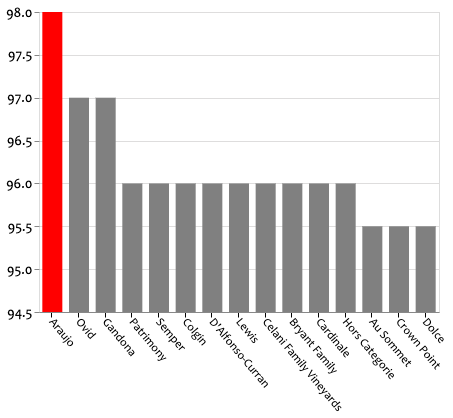

In [24]:
alt.Chart(test).mark_bar(color='grey', width=20).encode(
        alt.X('winery:N',
                  sort=alt.EncodingSortField(
                  field='points',  # The field to use for the sort
                  op="sum",  # The operation to run on the field prior to sorting
                  order="descending"  # The order to sort in
              )),
        alt.Y('points:Q', 
              scale=alt.Scale(domain=[min(test.points) - 1, max(test.points)]) # clip from 80-100
             ),
        color=alt.condition(
            alt.datum.winery == test['winery'][0],
            #alt.datum.winery == test.max(),
            alt.value('red'),
            alt.value('grey')
        )
    ).properties(width=400, height=300) 

#test['points'].max()
#test['winery'][0]

#### This function takes the data, groups by and summarizes, ranks the order of rows, and then plots it in a ranked bar chart in altair

In [26]:
def sort_extract_plot(data, by, col, n=15, direction='desc'):
    """
    Sorts dataframe by column of interest and returns data to
    be entered into altair.
    
    Arguments:
    data -- (dataframe) dataframe to sort
    by -- (str) name of quantitative column to sort by
    col -- (str) name of column of interest
    n -- (int) number of rows to return (default=15)  
    direction -- (str) whether to sort the column by ascending or descending
                       order based on the by column (default='desc')
    """
    new_data = data.groupby(col)[[by]].mean()
    #new_data = new_data.sort_values(by=by, ascending=False).head(n).reset_index()

    if direction == 'desc': 
        new_data = new_data.sort_values(by=by, ascending=False).head(n).reset_index()
        ranked_bar = alt.Chart(new_data).mark_bar(color='grey').encode(
            alt.X(col +':N',
                      sort=alt.EncodingSortField(
                      field=by,  # The field to use for the sort
                      op="sum",  # The operation to run on the field prior to sorting
                      order='descending'  # The order to sort in
                  )),
            alt.Y(by + ':Q', 
                  scale=alt.Scale(domain=[min(new_data[by]), max(new_data[by])])
                 ),
            color=alt.condition(
                alt.datum[col] == new_data[col][0],
                alt.value('red'),
                alt.value('grey')
            )
        ).properties(width=700, height=300) 
        display(ranked_bar)
    else:
        new_data = new_data.sort_values(by=by, ascending=True).head(n).reset_index()
        ranked_bar = alt.Chart(new_data).mark_bar(color='grey').encode(
            alt.X(col +':N',
                      sort=alt.EncodingSortField(
                      field=by,  # The field to use for the sort
                      op="sum",  # The operation to run on the field prior to sorting
                      order='ascending'  # The order to sort in
                  )),
            alt.Y(by + ':Q', 
                  scale=alt.Scale(domain=[min(new_data[by])-1, max(new_data[by])])
                 ),
            color=alt.condition(
                alt.datum[col] == new_data[col][0],
                alt.value('red'),
                alt.value('grey')
            )
        ).properties(width=500, height=300) 
        return ranked_bar

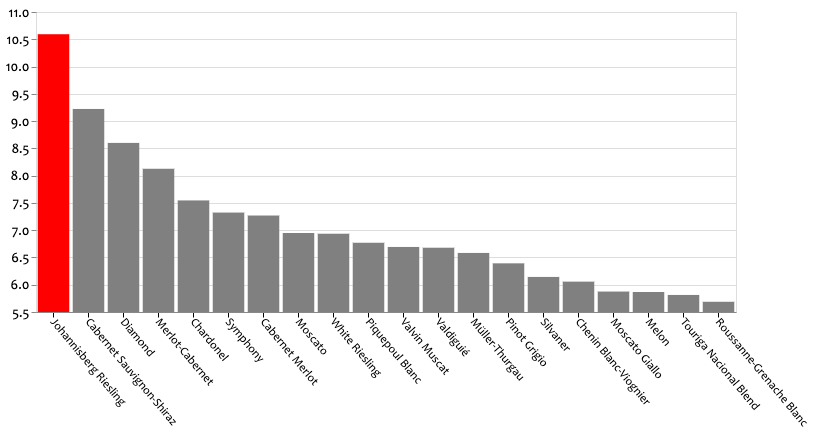

In [27]:
test2 = sort_extract_plot(cleaned_df, by='value', col='variety', n=20, direction='desc')


#### What about wine points vs price?

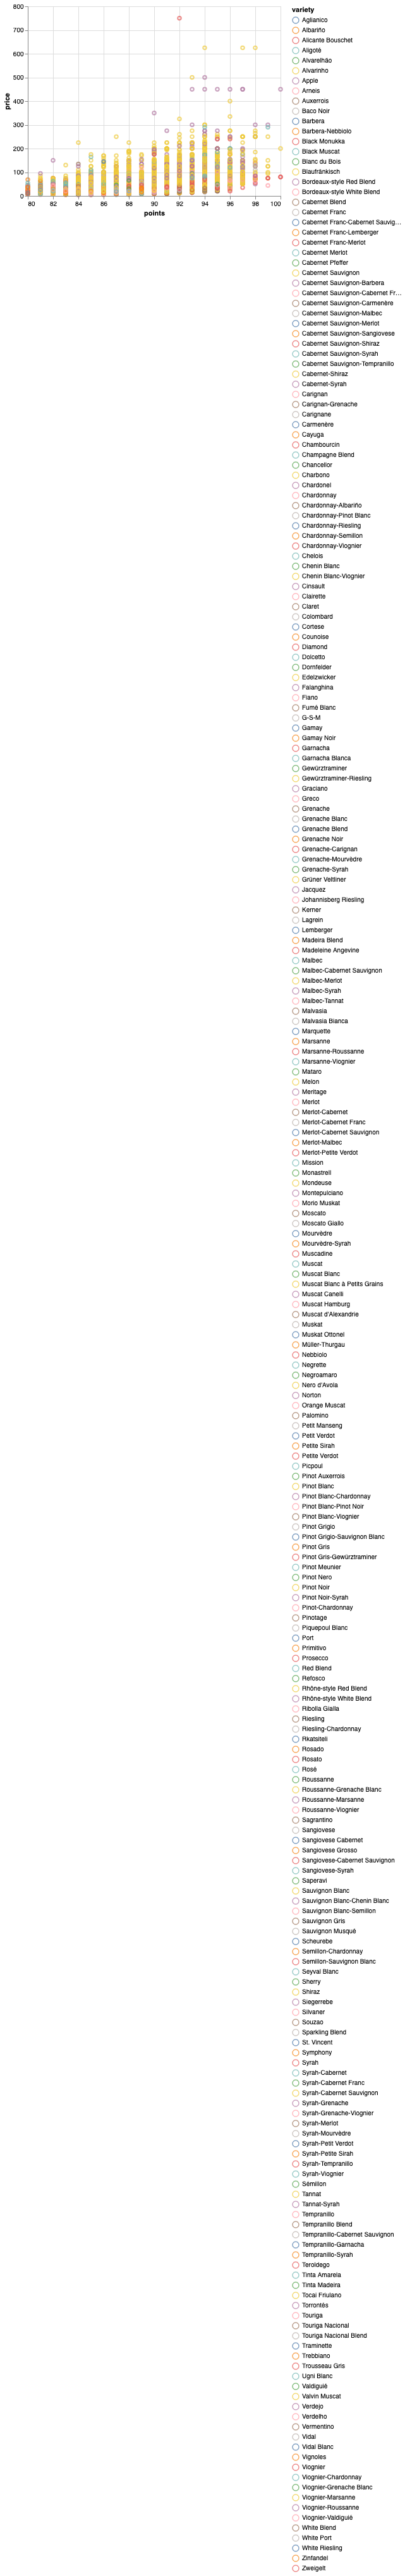

In [185]:
alt.Chart(merged_df).mark_point().encode(
    alt.X('points', scale=alt.Scale(zero=False)),
    alt.Y('price'),
    alt.Color('variety')
)

#### This looks pretty bad - what if we grouped wines by type (i.e. white, red, etc) and then used tooltip to identify the specific wine?